In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from time import time

# PCA Warm-up

Ces exercices d’échauffement vous aideront à acquérir une intuition sur le fonctionnement d’une **analyse en composantes principales**.





## (1) Générer les données

Nous voulons un ensemble de données avec **100 observations** et **2 caractéristiques corrélées**

👇 Exécutez la cellule ci-dessous pour générer vos données
💡 Notez la corrélation (élevée) entre vos deux caractéristiques.

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a dataset with 100 observations and 2 correlated features.
seed = np.random.RandomState(42)
feature_1 = seed.normal(5, 1, 100)
feature_2 = .7 * feature_1 + seed.normal(0, .5, 100)
X = np.array([feature_1, feature_2]).T
X = pd.DataFrame(X)

X.corr().round(3)

,0,1
0,1.00,0.77
1,0.77,1.00


❓ Dessinez un nuage de points de vos deux fonctionnalités l'une par rapport à l'autre

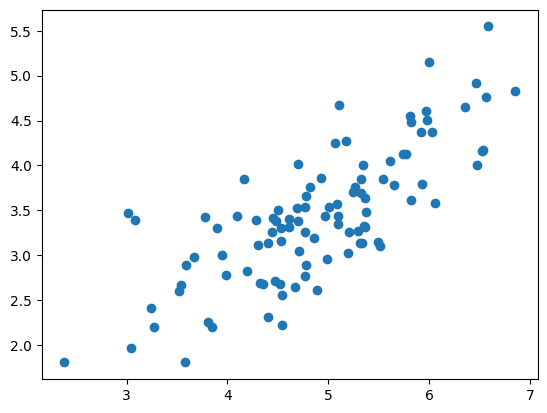

In [102]:
plt.scatter(X[0], X[1])
plt.show()

☝️ Vous pouvez identifier la corrélation positive entre les caractéristiques

Nos observations sont regroupées le long d'une seule ligne, il n'est pas facile de repérer les différences entre elles

💡 L'ACP nous aidera à trouver les directions (les soi-disant « composantes principales ») qui annulent cette corrélation.

## (2) Composantes principales

👉 Importez `PCA` depuis `sklearn` et instanciez un modèle avec `n_components=2`

❓Ajustez-le sur votre `X` et attribuez-le à `pca`

In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

Concentrons-nous sur deux objets dans cette `PCA` :

* `pca.components_` : c'est un ensemble de vecteurs propres qui pointent vers les directions où la variance est expliquée au maximum : les **directions de variance maximale**.

* `pca.explained_variance_` : $Var(Principal Component)$, donnée par la norme L2 correspondante de ces vecteurs propres.

* `pca.explained_variance_ratio_` : $ = \frac{Var(Principal\; Component)}{\sum Var(Principal\; Component)}$

In [104]:
# Vector coordinates of each Principal Component
pca.components_

array([[ 0.79286897,  0.60939216],
       [-0.60939216,  0.79286897]])

In [105]:
# Explained Variance for each Principal Component
# Ranked by decreasing order of importance
pca.explained_variance_

array([1.2231014 , 0.15046893])

In [106]:
# Explained Variance Ratio for each Principal Component
# Ranked by decreasing order of importance

# It is exactly the explained variance for each component...
# ... divided by the sum of explained variances !
pca.explained_variance_ratio_

array([0.89045415, 0.10954585])

👇 Exécutez la cellule ci-dessous pour visualiser vos deux composantes principales

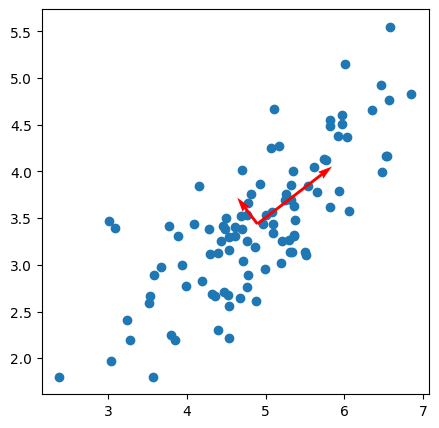

In [107]:
plt.figure(figsize=(5,5))

plt.scatter(X[0], X[1])

for (length, vector) in zip(pca.explained_variance_, pca.components_):
    v = vector * np.sqrt(length) # Square root of their lenghts to compare same "units"
    plt.quiver(*X.mean(axis=0), *v, units='xy', scale=1, color='r')

💡 La longueur du vecteur est une mesure de l'écart type de l'ensemble de données lorsqu'il est projeté sur cet axe !

💡 Nous pouvons ensuite utiliser ces directions (ces « composantes principales ») pour « expliquer » la plupart du comportement de nos observations - la plupart des distinctions entre les observations se produisent le long de ces axes.

## (3) Appliquer la PCA

Nous pouvons utiliser ces composants pour projeter chaque échantillon de notre ensemble de données sur les directions de variance maximale.

❓ ***Questions*** ❓

1. Utilisez la méthode `transform` de votre `pca` sur `X` et stockez le résultat dans `X_transformed`
2. Tracez vos entités projetées dans `X_transformed` les unes par rapport aux autres.
3. Calculez la corrélation entre vos entités transformées dans `X_transformed`

In [108]:
X_transformed = pca.transform(X)

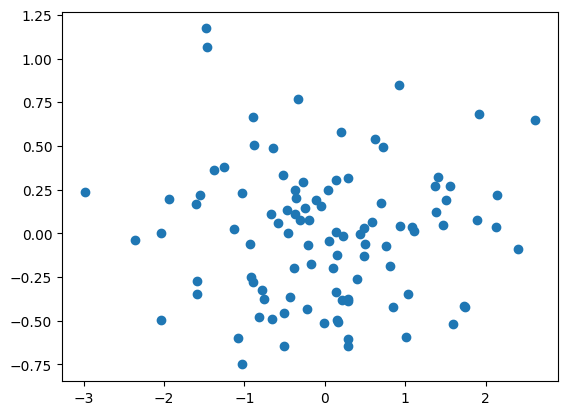

In [109]:
plt.scatter(X_transformed[:,0], X_transformed[:,1])
    

In [110]:
np.corrcoef(X_transformed)
# We have -1 and 1, it means that we don't have correlation.

array([[ 1., -1.,  1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ..., -1., -1.,  1.],
       [ 1., -1.,  1., ...,  1.,  1., -1.],
       ...,
       [ 1., -1.,  1., ...,  1.,  1., -1.],
       [ 1., -1.,  1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ..., -1., -1.,  1.]])

☝️ Il n'y a aucune corrélation entre vos entités transformées.

Cela facilite l'étude du comportement entre les observations puisqu'elles ne sont plus regroupées le long d'une seule ligne.

# Reconnaissance faciale

Dans cet exercice, nous allons
* utiliser l'ACP pour **compresser des images en noir et blanc de personnes célèbres**
* utiliser nos images compressées comme échantillons pour une tâche de classification

Cette fois, contrairement à l'exercice K-means précédent :

Au lieu d'effectuer un apprentissage non supervisé sur **une image** pour trouver des motifs **entre ses pixels** afin de réduire ses numéros de couleur uniques, nous allons travailler sur un ensemble de données de **plusieurs images N&B** pour :

- trouver des motifs communs **entre toutes les images**
- réduire le nombre de « caractéristiques principales » qui les décrivent

Plus précisément, nous allons essayer d'exprimer chaque image de notre ensemble de données comme une **combinaison linéaire de composantes principales** (images principales dans ce cas, si vous voulez) en utilisant l'ACP.

Pour compresser nos images, nous allons ensuite **mettre à zéro les plus petites composantes principales** et ne conserver que les plus importantes dans l'équation. Chaque « combinaison linéaire réduite » représentera une image qui a été compressée.

Heureusement, comme nous n'avons supprimé que les composants les moins importants, notre projection de dimension inférieure de l'ensemble de données préservera la variance maximale des données entre les images, nous devrions donc toujours être en mesure de reconnaître quelle personne se trouve sur chaque image.

## 1) Charger les données

❓ Exécutez la cellule ci-dessous pour télécharger une copie du célèbre ensemble de données LFW fourni par « Sklearn ».

In [111]:
# from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(data_home='data_', min_faces_per_person=70, resize=0.4, funneled=False)

💡 L'objet **faces** contient les éléments suivants :
- `faces.images` : images sous forme de matrices de **50 x 37 pixels** que vous pouvez tracer
- `faces.data` : version aplatie de taille **1850 x 1** *(50 x 37=1850)*
- `faces.target` : index numérique représentant une classe parmi 7

❓ Exécutez les cellules ci-dessous pour vérifier certains faits de base sur vos données et voir quelques images


In [112]:
print(f"- Images shape: {faces.images.shape}")
print(f"- Data (flattened images) shape: {faces.data.shape}")
print(f"- Target shape: {faces.target.shape}")
print(f"- Number of classes: {np.unique(faces.target).shape}")
print(f"- Each class is a famous person: {', '.join(faces.target_names)}")

- Images shape: (1288, 50, 37)
- Data (flattened images) shape: (1288, 1850)
- Target shape: (1288,)
- Number of classes: (7,)
- Each class is a famous person: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair


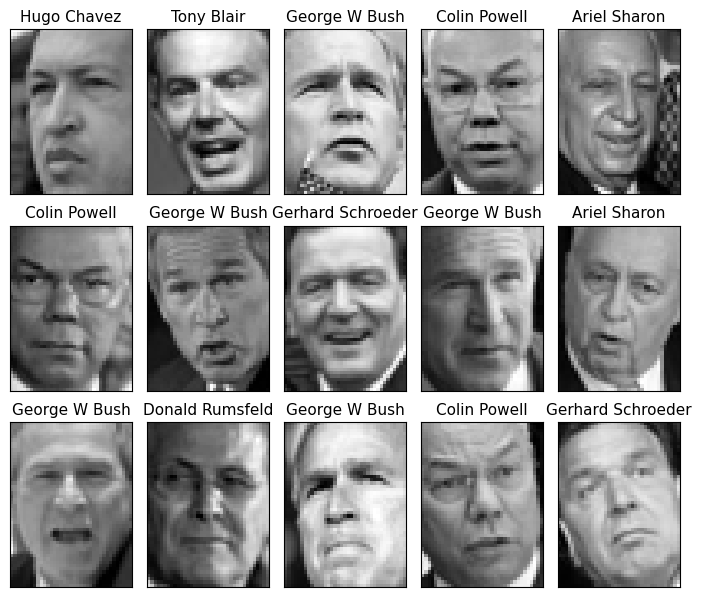

In [113]:
# Let’s see some faces.
fig = plt.figure(figsize=(7,10))

for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()


## 2) Compression avec PCA

Nous avons **1288** observations (images) et **1850** caractéristiques (50 × 37 pixels).

Avoir autant de caractéristiques pour si peu d'observations n'est pas une bonne chose en Machine Learning ; en règle générale, vous voudrez peut-être au moins : $n_{caractéristiques} << \sqrt{n_{observations}}$.

**PCA** peut aider à réduire ces caractéristiques à une taille plus gérable tout en conservant la plupart des informations dans les données.

❓ Ajustez une `PCA` sur vos **images aplaties** pour réduire leurs dimensions à 150 composants
👉 Stockez votre `PCA` ajustée dans une variable nommée **pca**
👉 Puis attribuez leur transformation à **data_projected**

In [114]:
pca = PCA(n_components=150)
data_projected = pca.fit_transform(faces.data) 

Les images ont été projetées sur les 150 premières composantes principales uniquement.

Encore une fois, ce que nous appelons des composantes sont les **directions de variance maximale** des données.

Maintenant, nous n'avons plus besoin de 1850 pixels pour décrire chaque image, mais seulement de 150 valeurs 🤓

Un gain par facteur de $\frac{1850}{150} = 12$ 🚀

❓ Regardez la forme de vos composantes et assurez-vous de bien comprendre ce qu'elle représente
❓ Regardez la forme de votre première composante, encore une fois, assurez-vous de bien comprendre ce qu'elle représente

In [115]:
data_projected[0]
# If I understand correctly, this represents an image.

array([ 1.6194347 , -1.5077213 ,  0.03703579,  0.3575363 , -0.4834133 ,
       -0.40103576, -0.2069013 , -0.8949712 ,  0.2712745 ,  0.21293354,
        0.6977633 ,  0.24564719, -1.0069641 ,  0.51956254,  0.11297712,
       -0.78403413,  0.7843391 ,  0.49788612,  0.0487008 ,  0.17597255,
        1.1609465 ,  0.6024539 ,  0.14642583,  0.51636875,  0.61078435,
        0.4805086 , -0.5947934 , -0.45914498, -0.13955481,  0.1825414 ,
        0.10621578, -0.06717999, -0.6639899 , -0.53942245,  0.72193515,
        0.7679981 ,  0.032247  , -0.4483531 ,  0.366188  ,  0.35154468,
       -0.07433534, -0.07389747,  0.2280892 ,  0.8195909 , -0.14146136,
        0.26153353, -0.42474785,  0.34945872, -0.14773925, -0.5265884 ,
       -0.29080126, -0.44547018,  0.52138   , -0.1027083 ,  0.10519635,
        0.00892195, -0.22887443,  0.34478387, -0.15529647, -0.28658223,
       -0.22216004, -0.0493811 ,  0.29922795,  0.21877196, -0.09017204,
        0.02427379,  0.107013  ,  0.3510052 ,  0.48025945, -0.33

❓ Tracez la 13e image (George W. Bush) de l'ensemble de données reconstruit et comparez-la à l'original.


<summary>💡Astuce</summary>
Remodelez les données aplaties en une image de 50 x 37 pixels
</détails>

In [116]:
image_projected = pca.inverse_transform(data_projected[12].data)

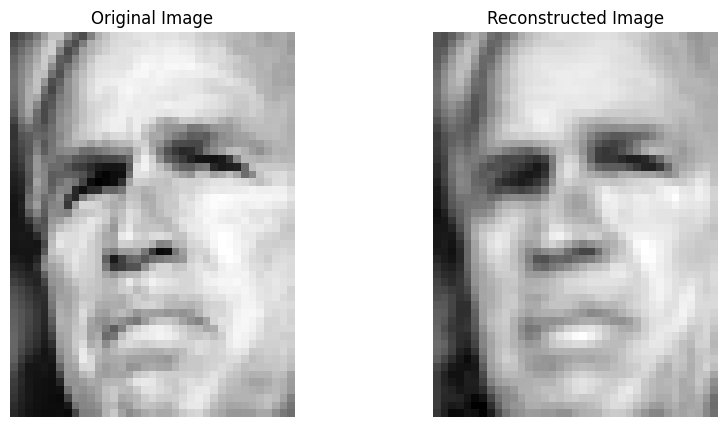

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(faces.data[12].reshape(50, 37), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(image_projected.reshape(50, 37), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.show()

❓ Exécutez la cellule ci-dessous pour voir une sélection d'images reconstruites

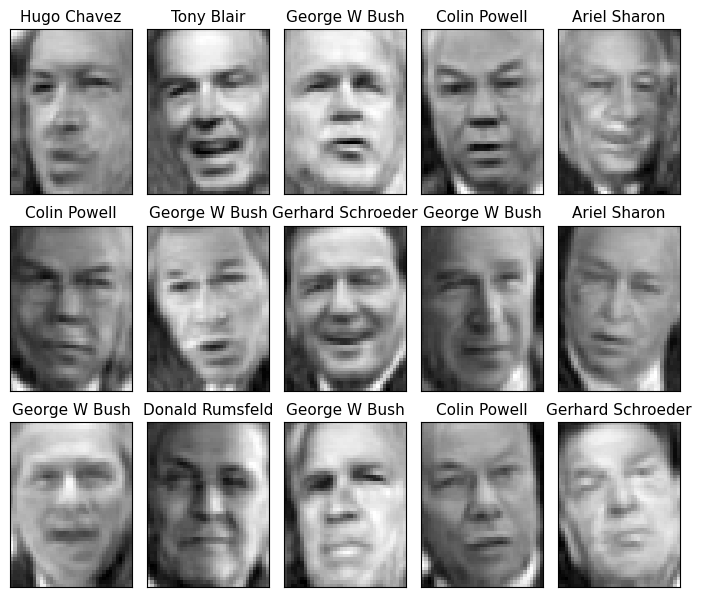

In [118]:
fig = plt.figure(figsize=(7, 10))

for i in range(15):
    plt.subplot(5, 5, i + 1)

    # Display each image with a title, which we grab from the dataset
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(pca.inverse_transform(data_projected)[i].reshape((50,37)), cmap=plt.cm.gray)

    # Remove plot ticks
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

## 3) Étudiez vos composantes principales

❓ Tracez une image qui correspond à la face *\"moyenne\"* de l'ensemble des données
👉 Utilisez une carte de couleurs « gris » pour vos affichages dans cette section

<détails>
<summary>💡Astuce</summary>

Vous pouvez utiliser `pca.mean_` ou `faces.data.mean(axis=0)`
Vous aurez également besoin d'un certain reformatage pour pouvoir le tracer sous forme d'image
</details>

❓ Tracez les images correspondant aux **5 premières** composantes principales

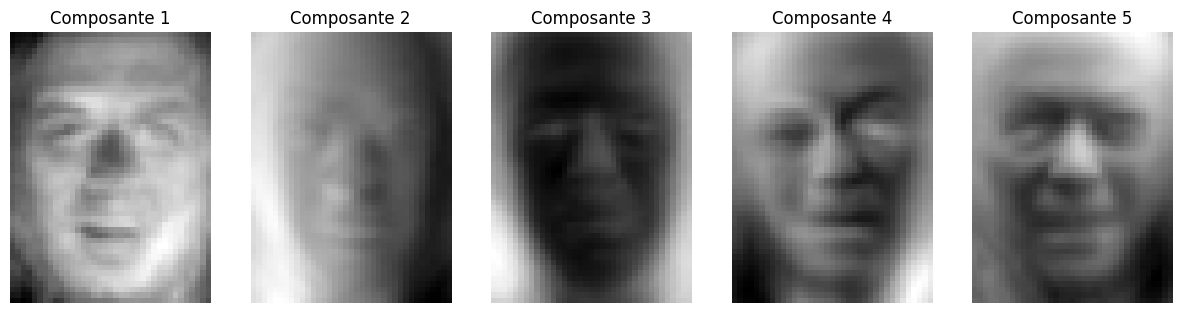

In [119]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    pca_five_image = pca.components_[i].reshape(50, 37)
    ax.imshow(pca_five_image, cmap='gray')
    ax.set_title(f"Composante {i+1}")
    ax.axis('off')
plt.show()

☝️ Chaque Composante principale (PC) est une « image » aplatie de 1850 pixels
Nous les avons simplement remodelés pour pouvoir les visualiser comme des images normales

👇 Vous trouverez ci-dessous une liste de définitions de ces composantes principales

❓ **Lisez-les attentivement et assurez-vous de bien les comprendre**

💡 Vos premiers PC sont les **directions_ les plus importantes** sur vos observations de 1850 éléments

💡 Ce sont les **combinaisons linéaires_ les plus importantes de vos 1850 pixels

💡 Celles qui **préservent le plus de _variance_** lorsque votre ensemble de données d'images est projeté sur elles

💡 Les premiers PC sont les **régions de la grille de pixels 2D qui contiennent le _plus de variation_** entre vos 1288 images

❓ Tracer les images correspondant aux **5 dernières** composantes principales

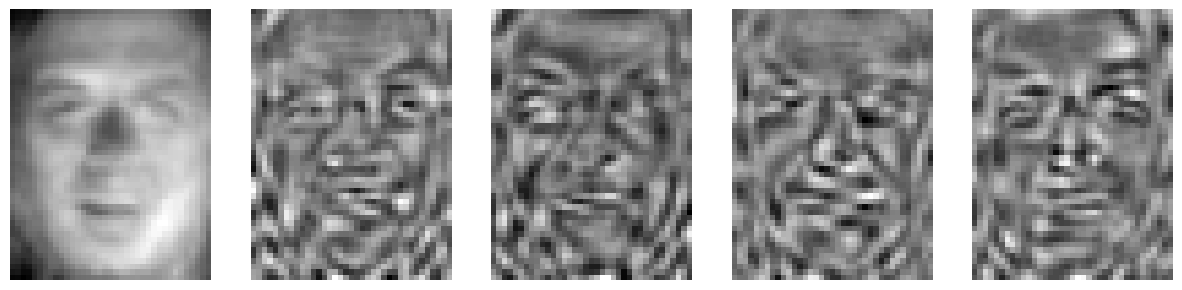

In [120]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    pca_five_image = pca.components_[-i].reshape(50, 37)
    ax.imshow(pca_five_image, cmap='gray')
    ax.axis('off')
plt.show()

❓Tracer plusieurs images correspondant aux composantes principales

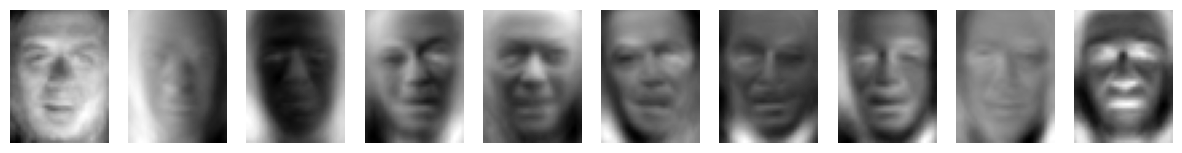

In [121]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    pca_five_image = pca.components_[i].reshape(50, 37)
    ax.imshow(pca_five_image, cmap='gray')
    ax.axis('off')
plt.show()

## 4) Choisissez le nombre optimal de composants

Nous rencontrons, comme c'est souvent le cas en Machine Learning, un compromis ⚖️

**De nombreux composants** donneront une image compressée qui est :
🙂 Proche de l'image originale en termes de qualité
🙁 Pas significativement plus claire que l'image originale

**Quelques composants** donneront une image compressée qui est :
🙂 Significativement plus claire que l'originale
🙁 Loin de l'image originale en termes de qualité

Il est très important de trouver combien de composants sont nécessaires pour décrire les données sans perdre trop d'informations

Nous pouvons le déterminer visuellement en traçant le ratio de la somme cumulative des variances expliquées en fonction du nombre de composants

Ces informations sont stockées dans l'attribut `explained_variance_ratio_` d'un objet `PCA` ajusté de `sklearn`

❓ Tracez le ratio de la somme cumulative des variances expliquées en fonction du nombre de composants

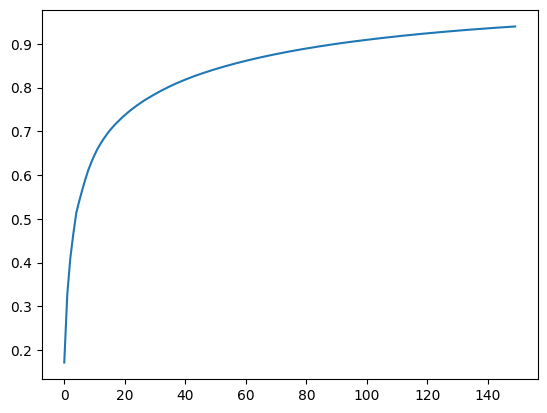

In [122]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

☝️ Cette courbe quantifie la part de la variance totale contenue dans les premières composantes

❓ Exécutez la cellule ci-dessous et prenez le temps de confirmer les affirmations avec votre compréhension du graphique :
- La **première composante** à elle seule suffit à expliquer près de **20 % de la variance**
- Les **25 premières composantes** suffisent à expliquer près de **75 % de la variance**
- Nous avons besoin d'environ **94 composantes** pour décrire **90 % de la variance**

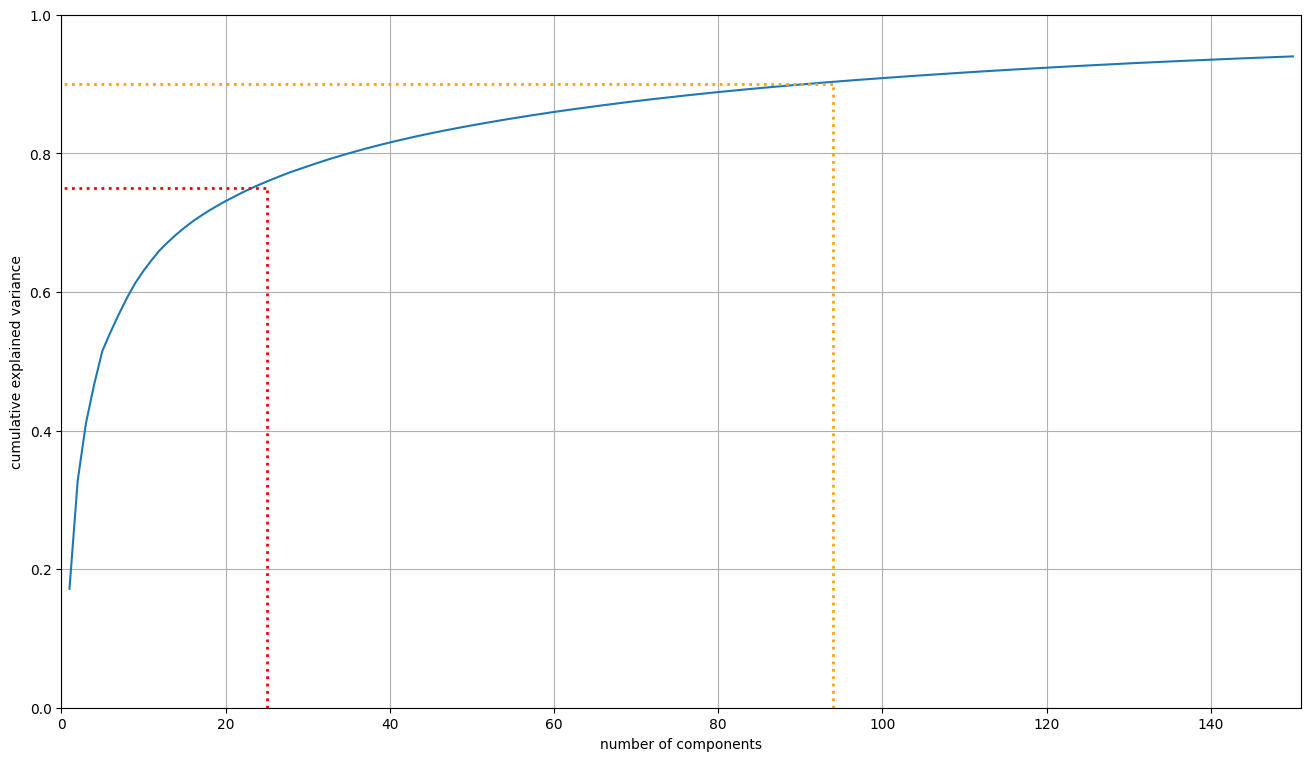

In [123]:
plt.figure(figsize=(16, 9))

# Plot the data
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_))

# Set labels
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# Display grid in the background
plt.grid()

# Set the limits for the axes
plt.xlim((0, 151))
plt.ylim((0, 1))

# Add lines to the plot
plt.hlines(
    y=[.75, .9],
    xmin=[-5, -5],
    xmax=[25, 94],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
)
plt.vlines(
    x=[25, 94],
    ymin=[0, 0],
    ymax=[.75, .9],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
);

❓ Quel est le plus petit nombre de composants que vous devez conserver pour obtenir au moins 80 % de la variance ?
👉 Affectez votre réponse à une variable nommée `minimal_pc_count`

In [124]:
minimal_pc_count = 35

## 5) Classer les images (PCA comme ingénierie des fonctionnalités)

Il est temps d'utiliser l'ACP comme outil de ML supervisé.

Voici votre objectif 👇

Étant donné une photo du visage d'une personne célèbre parmi une sélection, votre modèle devrait être capable de dire à qui appartient le visage.

Traduction de ce brief en termes de ML 👇

Vos échantillons sont des images
Vos caractéristiques sont leurs pixels
Votre cible est une classe parmi plusieurs

❓ Validez de manière croisée un modèle SVC avec des pixels comme caractéristiques, adapté à la tâche de classification en cours
👉 Enregistrez le temps nécessaire pour entraîner et évaluer votre modèle

<details span='markdown'>
<summary>💡Astuce </summary>
Vous pouvez utiliser la méthode suivante pour enregistrer le temps d'exécution :

```python
from time import time
start = time()
# CODE pour lequel vous souhaitez enregistrer le temps d'exécution
execution_time = time() - start
```
</details>

❓ Suivez les mêmes étapes, cette fois en utilisant les projections de vos images comme fonctionnalités

In [125]:
# Cross-validation with pixel-based SVC model
svc = SVC()

start = time()

score = cross_validate(svc, faces.data, faces.target)

final_time = time() - start



In [126]:
final_time

print('Temps mis :', final_time)

Temps mis : 4.047217130661011


In [127]:
score
# Cross-validation returns fit_time, score_time and test_score
# We don't need the first two because we have 'time' which does everything for us

{'fit_time': array([0.64502668, 0.61383057, 0.591048  , 0.5328474 , 0.49938154]),
 'score_time': array([0.2368536 , 0.25642419, 0.23296595, 0.21741867, 0.21665931]),
 'test_score': array([0.66666667, 0.66666667, 0.65503876, 0.6848249 , 0.66536965])}

In [128]:
precision_score = score['test_score'].mean()
print('On a une précision moyenne de :', precision_score)

On a une précision moyenne de : 0.6677133291104878


In [129]:
# We're doing the same with ACP now 
svc_pca = SVC()
start = time()
score_pca = cross_validate(svc_pca, data_projected, faces.target, cv=5, return_train_score=False)
final_time_1 = time() - start


In [130]:
print('Temps mis :', final_time_1)

Temps mis : 0.36858248710632324


In [131]:
precision_score_acp = score_pca['test_score'].mean()
print('On a une précision moyenne de :', precision_score_acp)

On a une précision moyenne de : 0.6646065212801255


👉 Comparez vos scores et vos temps d'exécution

La qualité de votre modèle devrait avoir *légèrement* diminué.
Le temps nécessaire pour *\"choisir\"* (entraîner et évaluer) le modèle, en revanche, devrait avoir *considérablement* diminué !

In [132]:
print('Temps mis sans ACP :', final_time, '\nTemps mis avec ACP :', final_time_1)
print()
print('Précision sans ACP :', precision_score, '\nPrécision avec ACP :', precision_score_acp)

# It's easy to see that time has been divided by 10

Temps mis sans ACP : 4.047217130661011 
Temps mis avec ACP : 0.36858248710632324

Précision sans ACP : 0.6677133291104878 
Précision avec ACP : 0.6646065212801255


## 6) Recherche du nombre optimal de composants

Cette fois, la méthode du Machine Learning : Grid Search.

💡 Maintenant que nous disposons d'un paramètre ML supervisé (cible de fonctionnalités), nous pouvons rechercher dans la grille le nombre optimal de composants.

❓ Avant de continuer, conservez 30 % de vos données comme ensemble de test

👉 Comme d'habitude, attribuez vos données fractionnées à `X_train`, `X_test`, `y_train`, `y_test`
👉 Dans votre `train_test_split`, utilisez `random_state=42` pour comparer les résultats avec votre ami

💡 Nous allons **sélectionner** notre modèle en **effectuant une validation croisée** sur l'**ensemble de train**
Ensuite, nous allons **évaluer** notre modèle en le **notant** sur l'**ensemble de test**

In [133]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size = 0.3, random_state=42)

Avec Train

In [134]:
svc_pca = SVC()
start = time()
score_pca_train = cross_validate(svc_pca, X_train, y_train, cv=5, return_train_score=False)
final_time__train = time() - start


In [135]:
print('Temps mis :', final_time__train)
precision_score_acp_train = score_pca_train['test_score'].mean()
print('On a une précision moyenne de :', precision_score_acp_train)

Temps mis : 1.714951753616333
On a une précision moyenne de : 0.5926764886433394


Avec Test

In [136]:
svc_pca = SVC()
start = time()
score_pca_test = cross_validate(svc_pca, X_test, y_test, cv=5, return_train_score=False)
final_time__test = time() - start


In [137]:
print('Temps mis :', final_time__test)
precision_score_acp_test = score_pca_test['test_score'].mean()
print('On a une précision moyenne de :', precision_score_acp_test)

Temps mis : 0.3548624515533447
On a une précision moyenne de : 0.509090909090909


*On voit que le temps a drastiquement diminué mais la précision aussi*


💡 Une recherche de grille nécessite un pipeline
❓ Utilisez [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) pour créer un pipeline en deux étapes :
- Un `PCA`, pas besoin de choisir le nombre de composants maintenant
- L'algorithme [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) comme estimateur

In [138]:
pipeline = make_pipeline((PCA()),(SVC()))

❓ Créez une recherche de grille à validation croisée qui utilise votre pipeline
👉 Recherchez uniquement le nombre de composants pour votre « PCA » parmi ces options : « [50, 100, 200, 300] »

In [139]:
# pca__n_components specific to PCA
parameters = {'pca__n_components':[50, 100, 200, 300]}
search = GridSearchCV(pipeline, parameters)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()), ('svc', SVC())]),
             param_grid={'pca__n_components': [50, 100, 200, 300]})

In [140]:
best_estimator = search.best_estimator_
# the best n_components is 100.

❓ Imprimez le [rapport de classification](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) de votre meilleur modèle
👉 Utilisez le « meilleur estimateur » de votre recherche de grille pour obtenir des prédictions à partir de **X_test**
👉 Utilisez ces prédictions par rapport à **y_test** pour imprimer votre rapport de classification

In [141]:
y_pred = best_estimator.predict(X_test)

In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.28      0.43        18
           1       0.75      0.70      0.72        69
           2       0.86      0.56      0.68        34
           3       0.62      0.96      0.75       166
           4       0.90      0.29      0.44        31
           5       1.00      0.05      0.10        19
           6       0.68      0.38      0.49        50

    accuracy                           0.67       387
   macro avg       0.83      0.46      0.52       387
weighted avg       0.73      0.67      0.63       387



Vous pouvez obtenir un UndefinedMetricWarning si pour l’une des classes, il n’y a pas de prédictions correctes.

❓ Combien de composants donnent le meilleur score ?
👉 Affectez la valeur à une variable nommée **best_n_components**

In [143]:
best_n_components = search.best_params_['pca__n_components']
print("Meilleur score :", best_n_components)


Meilleur score : 100


## 7) Reconstruction d'une image originale

👉 Étudiez les cellules ci-dessous qui reconstruisent l'image étape par étape sans `inverse_transform`

👉 Nous commençons par sélectionner une seule image pour l'exemple

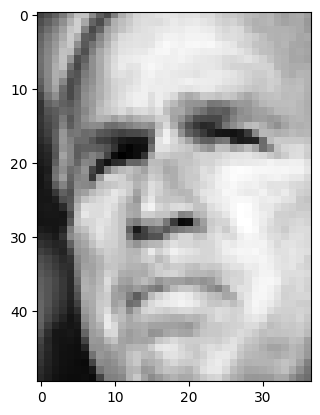

In [144]:
# Let's reconstruct the 13th image
image_original = faces.images[12];
image_compressed = data_projected[12];

plt.imshow(image_original, cmap='gray');

👉 On fait manuellement la somme des multiplications $X\_ reconstruit _{i} = \sum_{i=1}^{n\_ composantes}{X_{projeté _i} * X_i}$
$W_i$ étant la `i-ième composante principale`

In [145]:
# We start the reconstruction from the mean of all images
image_reconstructed = pca.mean_.copy();

# Then, reconstruct the image by computing the sum of every 150 entries of its compressed representation, weighted by the corresponding principal components
reconstruction = list()

for i in range(pca.n_components_):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    reconstruction.append(image_reconstructed.copy())

In [146]:
len(reconstruction)

150

👉 Nous traçons l'image reconstruite à côté de l'original

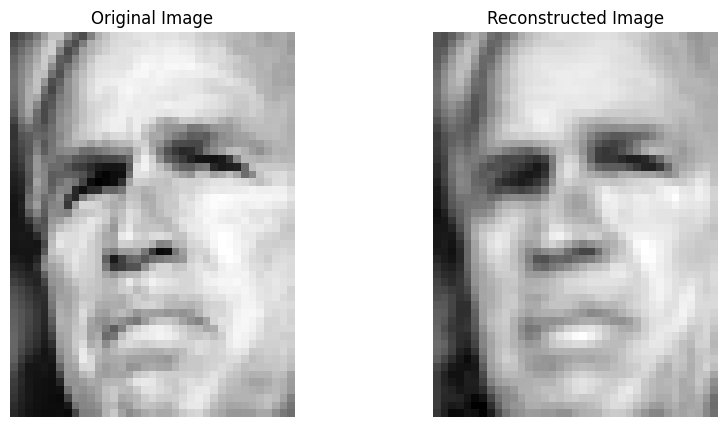

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_original, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(image_reconstructed.reshape(50, 37), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.show()

👉 Nous traçons l'image à différentes étapes de reconstruction

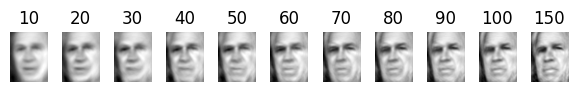

In [148]:
# We start the reconstruction from the mean of all images
image_reconstructed = pca.mean_.copy()

# Step for the reconstruction
steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, pca.n_components_]  # Etapes où nous allons afficher la reconstruction

# Reconstruction and display each step
for idx, step in enumerate(steps, start=2):
    image_reconstructed = pca.mean_.copy()  # Restart with the "mean image"
    for i in range(step):
        image_reconstructed += pca.components_[i] * image_compressed[i]

    plt.subplot(1, 12, idx)
    plt.imshow(image_reconstructed.reshape(50, 37), cmap='gray')
    plt.title(f"{step}")
    plt.axis('off')

plt.tight_layout()
plt.show()
